In [324]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import pandas as pd
import random as random
import numpy as np
import scipy as sp
import networkx as nx
import warnings 
warnings.filterwarnings("ignore") # GP struggles to converge sometimes, ignored for now
import time
from sklearn.model_selection import ParameterGrid

import seaborn as sns
from matplotlib import pyplot as plt

import nklsgen
import random

In [325]:
def extract_edgelist(G):
    nodes = list(G.nodes)
    edges = []
    
    for node in nodes:
        edges.append(sorted(list(G[node])))
        
    return dict(zip(nodes, edges))


def random_starts(landscape, points, min_=False):
    items = list(landscape.items()).copy()
    if min_:
        ls_size = len(landscape)
        tenth = int(round(ls_size/10, 0))
        decile = sorted(items, key=lambda x: x[1])[:tenth]
        picks = random.choices(decile, k=points)
    else:    
        picks = random.choices(items, k=points)
    
    start_points = [[pick[0], pick[1]] for pick in picks]
    #start_points = [[nklsgen.str_to_bin(pick[0]), pick[1]] for pick in picks]
    return start_points


def one_step_genotypes(genotype):
    base = genotype.copy()
    one_steps = []
    for i in range(len(base)):
        new = base.copy()
        if new[i] == 0:
            new[i] += 1
        elif new[i] == 1:
            new[i] -= 1
        one_steps.append(new)
    return one_steps


def hist_df_maker(pop):
    hist_dfs = []
    for agent in pop.agents:
        hist_dfs.append(agent.search_hist.copy())
    return pd.concat(hist_dfs)

In [326]:
def bin_to_str(code):
    string = str()
    for each in code:
        string += (str(each))
    return string

def str_to_bin(code):
    return [int(each) for each in code]

def bin_to_dec(bin_):
    key = np.power(2, np.flip(np.arange(len(bin_))))
    return np.sum(bin_ * key)


def distances_from_current(landscape_index, locs_bin):
    distances = [distance_from_many_to_one(point, locs_bin) for point in landscape_index]
    return distances

def distance_from_many_to_one(point, locs_bin): 
    distances = [euclidean_distance(point, loc) for loc in locs_bin]
    return min(distances)

def euclidean_distance(a, b):
    val = np.sum([(b[i]-a[i])**2 for i in range(len(a))])
    return np.sqrt(val)

def vectorized_dist(curr_loc, neigh_locs, landscape_index):
    curr_dists = sp.spatial.distance.cdist(landscape_index, curr_loc, 'cityblock')
    if len(neigh_locs) > 0:
        neigh_dists = sp.spatial.distance.cdist(landscape_index, neigh_locs, 'cityblock') + 1
        all_dists = np.concatenate([curr_dists, neigh_dists], axis=1)
    else:
        all_dists = curr_dists
    return all_dists.min(axis=1)  

In [345]:
class Agent():

    def __init__(self, search_cost=0, memory=None, myopic=False, 
                 edgelist=None, id_=None, start_point=None, landscape_index=None):
        
        self.id = id_
        self.myopic = myopic
        self.landscape_index = landscape_index
            
        self.search_cost = search_cost    
        self.memory = 0 if myopic else memory
        self.edgelist = edgelist
        self.neighbors = []
        
        start_point.append(self.id)
        start_point.append(0)
        self.search_hist = pd.DataFrame(columns=['Location', 'Value', 'AgentID', 'Step'])
        self.search_hist.loc[len(self.search_hist)] = start_point
        
        self.shared_search_hist = self.search_hist.copy()
        
        # GP kernel parameters
        self.kernel = RBF(length_scale=5,
                          length_scale_bounds=(1e-20,1e8))
        self.gp = GaussianProcessRegressor(kernel=self.kernel,
                                           n_restarts_optimizer=0)
        
        
    def update_shared_hist(self, teach=False, learn=True):
        if self.shared_search_hist.iloc[-1,:].values.tolist() != self.search_hist.iloc[-1,:].values.tolist():
            self.shared_search_hist.loc[len(self.shared_search_hist)] = self.search_hist.iloc[-1,:].values.tolist()
#         if len(self.shared_search_hist) != 1:
#             self.shared_search_hist.loc[len(self.shared_search_hist)] = self.search_hist.iloc[-1,:].values.tolist()
        for agent in self.neighbors:
            new_data = agent.search_hist.iloc[-1,:].values.tolist()
            self.shared_search_hist.loc[len(self.shared_search_hist)] = new_data
            
            
    def survey(self):
        
        # CHANGE SHARED TO FALSE FOR INDIVIDUAL TESTING
        
        #start_time = time.time()
        
        if self.myopic:
            amount = ((len(self.neighbors)+1) * 1)
            relevant_hist = self.shared_search_hist.sort_values(by=['Step'])[-amount:].copy()
            
        if not self.myopic:
            amount = ((len(self.neighbors)+1) * self.memory)
            relevant_hist = self.shared_search_hist.sort_values(by=['Step'])[-amount:].copy()
            
        locs = relevant_hist['Location'].apply(nklsgen.str_to_bin).tolist()
        vals = relevant_hist['Value'].tolist()

        self.gp.fit(locs, vals)
        y_est, std = self.gp.predict(self.landscape_index, return_std=True)
        
        return y_est, std

    
    def choose_new_point(self, landscape, capped=False): 
        
        # GP Agent 
        if not self.myopic:
            # Expected Values + Curiosity
            y_est, std_ = self.survey()
            std = std_ * 0.5 # <-- Uncertainty Value Here
            expected_value = y_est + std
            max_ = expected_value.max()
            expected_value = expected_value / max_
#             expected_value = [(a[0] + a[1]*0.50) for a in zip(y_est,std)] # <-- UNCERTAINTY VALUE HERE

            # Distances
            amount = ((len(self.neighbors)+1) * self.memory)
            if capped:
                opts = self.shared_search_hist.sort_values(by=['Step'])[-amount:].index.tolist()
                if len(opts) < 5:
                    inds = random.sample(opts, k=len(opts))
                else:
                    inds = random.sample(opts, k=5)
                relevant_hist = self.shared_search_hist[self.shared_search_hist.index.isin(inds)].copy()
            else:
                relevant_hist = self.shared_search_hist.sort_values(by=['Step'])[-amount:].copy()                
                
            curr_loc_df = self.search_hist.sort_values(by=['Step'])[-1:].copy()
            self_idx = relevant_hist[(relevant_hist['AgentID']==curr_loc_df.iloc[-1,2]) &
                                    (relevant_hist['Step']==curr_loc_df.iloc[-1,3])].index
            relevant_hist.drop(index=self_idx, inplace=True)
            
            curr_loc = np.array(curr_loc_df['Location'].apply(nklsgen.str_to_bin).tolist())
            neigh_locs = np.array(relevant_hist['Location'].apply(nklsgen.str_to_bin).tolist())
            
            distances = vectorized_dist(curr_loc, neigh_locs, np.array(self.landscape_index.copy()))
            
#             OLD CODE FOR DISTANCES (pre-scipy)
#             relevant_hist = self.shared_search_hist.sort_values(by=['Step'])[-amount:].copy() 
#             locs_bin = relevant_hist['Location'].apply(nklsgen.str_to_bin).tolist()
#             distances = distances_from_current(self.landscape_index, locs_bin)

            ## Search Cost
            max_dist = distances.max()
#             search_loss = distances / max_dist
            search_loss = distances
            search_loss = search_loss * np.array(self.search_cost)
            values = expected_value - search_loss
#             values = np.array([(a[0] - (a[1]*self.search_cost)) for a in zip(expected_value,distances)])
#             values = np.array([a for a in expected_value])

            ## Softmax Choice
            tau = 0.02
            softmax = np.exp(values/tau) / sum(np.exp(values/tau))
            softmax_dict = dict(zip(softmax.copy(), values.copy()))
            options = dict(sorted(softmax_dict.items(), reverse=True))
            choice = random.choices(list(options.values()), weights=list(options.keys()), k=1) 
            loc = np.where(values == choice)[0][0] 
        
        ## Myopic Agent
        if self.myopic:
            selfloc = self.search_hist.sort_values(by=['Step'])[-1:].copy()
            selfloc = selfloc['Location'].apply(nklsgen.str_to_bin).tolist()[-1]
            one_hops = one_step_genotypes(selfloc)
            one_hop_vals = [landscape[bin_to_str(i)] for i in one_hops]
            
            amount = ((len(self.neighbors)) * 1)
            relevant_hist = self.shared_search_hist[-amount:] 
            zero_hops = relevant_hist['Location'].apply(nklsgen.str_to_bin).tolist()

            idxmax_neighbor = relevant_hist['Value'].idxmax()
                       
            # Random roll for myopics to walk one unit in any direction
            if len(self.neighbors) == 0:
                random_step = random.choices(one_hop_vals, k=1)
                if random_step > self.search_hist.iloc[-1,:]['Value']:
                    index = one_hop_vals.index(random_step)
                    loc = bin_to_dec(one_hops[index])
                else:
                    loc = bin_to_dec(selfloc)
                    
#                 if max(one_hop_vals) >= self.search_hist.iloc[-1,:]['Value']:
#                     max_index = one_hop_vals.index(max(one_hop_vals))
#                     loc = bin_to_dec(one_hops[max_index])
#                 else:
#                     loc = bin_to_dec(selfloc)

            elif self.shared_search_hist.iloc[idxmax_neighbor,:]['Value'] > self.search_hist.iloc[-1,:]['Value']:
                bin_loc = nklsgen.str_to_bin(self.shared_search_hist.iloc[idxmax_neighbor,:]['Location'])
                loc = bin_to_dec(bin_loc)
                
            else:
                random_step = random.choices(one_hop_vals, k=1)
                if random_step > self.search_hist.iloc[-1,:]['Value']:
                    index = one_hop_vals.index(random_step)
                    loc = bin_to_dec(one_hops[index])
                else:
                    loc = bin_to_dec(selfloc)
                    
        return self.landscape_index[loc]
    
    
    def choose_and_move(self, landscape):
        new_loc_bin = self.choose_new_point(landscape)
        new_val = landscape[bin_to_str(new_loc_bin)]
        new_loc = bin_to_str(new_loc_bin)
        
        self.search_hist.loc[len(self.search_hist)] = [new_loc, new_val, self.id, len(self.search_hist)]
    
    
    def explore(self, landscape, steps):
        for _ in range(steps):
            start = time.time()
            self.choose_and_move(landscape)
            end = time.time()
            #print(f'Time Required per Step: {round(end-start,0)}')

class Population():
    
    def __init__(self, ls_params, num_searches, graph,
                 search_costs, memorys, myopia,
                 pop_id=None, graph_id=None):
        
        # Landscape Creation/Index
        ls_start = time.time()
        self.ls_params = ls_params
        self.landscapes = nklsgen.generate_landscapes(ls_params['N'], ls_params['K'], ls_params['num_of_ls'])
        self.landscape = self.landscapes[0].copy()
        self.landscape_index = [nklsgen.str_to_bin(each) for each in list(self.landscape.keys())]
        print(f'LS takes {round(time.time()-ls_start,0)} seconds!')
        
        self.num_searches = num_searches
        
        # Agents and Properties
        self.search_costs = search_costs
        self.memorys = memorys
        self.myopia = myopia
        self.graph = graph
        self.edgelist = self.graph.edgelist
        self.graph_id = self.graph.id
        self.graphdensity = graph.density
        
        # Create Agents
        self.agents = self.create_agents()
        
        self.time_per_step = []
        
    def create_agents(self):
        starts = random_starts(self.landscape, len(edgelist), min_=True)
        agents_ = []
        for i in range(len(edgelist)):
            agents_.append(Agent(self.search_costs[i], self.memorys[i], self.myopia, 
                                 self.edgelist[i], i, starts[i], self.landscape_index))
        
        for i in range(len(edgelist)):
            neighbors_ = [agents_[a] for a in self.edgelist[i]]
            agents_[i].neighbors = neighbors_
            agents_[i].update_shared_hist()
        
        return agents_
    
    
    def report_step_averages(self, step):
        
        agent_vals = []
        for agent in self.agents:
            agent_vals.append(agent.search_hist['Value'][step])
        
        return agent_vals
    
    
    def explore(self, sync=True):
        # Pop level explore function (round-based search)
        ## Could weave search and update together pretty easily
        ### Done by reversing the updating function
        for _ in range(self.num_searches):
            round_start = time.time()
            for agent in self.agents:
                agent.explore(self.landscape, 1)
                
                if not sync:
                    agent.update_shared_hist()
            self.time_per_step.append(round(time.time()-round_start,2))
#             print(f'Round end: {round(time.time()-round_start,2)}')
            
            sync_start = time.time()
            if sync:
                for agent in self.agents:
                    agent.update_shared_hist()
#             print(f'Sync end: {round(time.time()-sync_start,2)}')
                    
#         print(f'Sim Complete!')
        
        
def run_model(p_combo):
    sim_start = time.time()
    pop = Population(ls_params = p_combo['ls_params'],  
                     num_searches = p_combo['num_searches'], 
                     graph = p_combo['graphs'],
                     search_costs = p_combo['search_costs'],
                     memorys = p_combo['memorys'],
                     myopia = p_combo['myopia'],
                     pop_id = p_combo['pop_id'])

    pop.explore()
    
#     print(f'{time.time()-sim_start}')
    
    return pop

In [357]:
num_agents = 1
num_searches = [100]
densities = [i/10 for i in list(range(10,11))]
edges = [round(((num_agents*(num_agents-1)) / 2) * dens, 0) for dens in densities]

num_sims = 1

# Complete Graph
graphs_ = [nx.gnm_random_graph(num_agents, edge) for edge in edges]
# Chain Graph
# G = nx.Graph()
# for i in range(1,num_agents):
#     G.add_edge(i-1,i)
    
edgelists = [extract_edgelist(G) for G in graphs_]
class Graph():
    def __init__(self, edgelist, id_, density=None):
        self.id = id_
        self.edgelist = edgelist
        self.density = density
graphs = []
for i, edgelist in enumerate(edgelists):
    graphs.append(Graph(edgelist, i, nx.density(graphs_[i])))

# search_costs__ = [a/100 for a in list(range(0,21,2))]
search_costs__ = [0.0]
search_costs = [[i for _ in range(num_agents)] for i in search_costs__]

memorys_ = [1]
memorys = [[i for _ in range(num_agents)] for i in memorys_]

myopia = [False]

# pop_id = 0
# graph_id = 0

N = [17]
K = [5]
num_of_ls = [1]
ls_param_grid = {'N': N, 'K': K, 'num_of_ls': num_of_ls}
ls_params = list(ParameterGrid(ls_param_grid))

# Create Simulation ParamGrid
parameter_grid = {'ls_params': ls_params,  
                'num_searches': num_searches, 
                'graphs': graphs,
                'search_costs': search_costs,
                'memorys': memorys,
                'myopia': myopia}

# Create list of Param_Combos
parameter_combos = list(ParameterGrid(parameter_grid))
parameter_combos = [a for a in parameter_combos.copy() for _ in range(num_sims)]

for i, pcombo in enumerate(parameter_combos):
    pcombo.update({'pop_id': i})

sim_start = time.time()
sim_hist = []
for p_combo in parameter_combos:
    sim_start_ = time.time()
    sim_hist.append(run_model(p_combo))
    print(f'Sim Complete: {time.time()-sim_start_}')
print(f'Time Taken (sec): {time.time()-sim_start}')

LS takes 15.0 seconds!
Sim Complete: 51.25419092178345
Time Taken (sec): 51.439571142196655


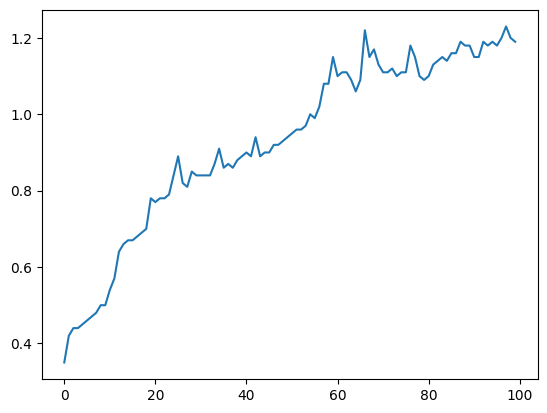

In [356]:
y = sim_hist[0].time_per_step
x = range(len(y))

plt.plot(x,y)

In [288]:
sim_index = []
step_index = []
avg_value = []
search_costs_= []
memories = []
densities_ = []
ls_params_ = []
pop_ids_ = []
graph_ids_ = []

for i, pop in enumerate(sim_hist):

    # filename_ = f'./{folder_}/landscapes/'
    # pop.landscape.tofile(f'{filename_}{pop.id_}_landscape.csv', sep=',')

    for j in range(pop.num_searches+1):

        # Sim + Step Indices
        #sim_index.append(f'{rank}_{i+1}')
        step_index.append(j)

        # Average Agent Value at each Step
#         agent_vals = []
#         for agent in pop.agents:
#             agent_vals.append(agent.search_hist['Value'][j])
#         avg_value.append((sum(agent_vals) / len(agent_vals)))
        avg_value.append(np.mean(pop.report_step_averages(j)))

        # Agent Properties
        search_costs_.append(pop.search_costs[0])
        memories.append(pop.memorys[0])

        # Graph Properties
        densities_.append(pop.graphdensity)

        # IDs
        ls_params_.append(pop.ls_params)
#         pop_ids_.append(pop.pop_id)
#         graph_ids_.append(pop.graph_id)

data = {#'Sim_ID': sim_index, 
        'Step': step_index, 
        'AVG_Value': avg_value, 
        'Search_Cost': search_costs_,
        'Memory': memories,
        'Densities': densities_,
        'LS_Params': ls_params_
        #'Pop_IDs': pop_ids_,
        #'Graph_IDs': graph_ids_
        }


df = pd.DataFrame(data)

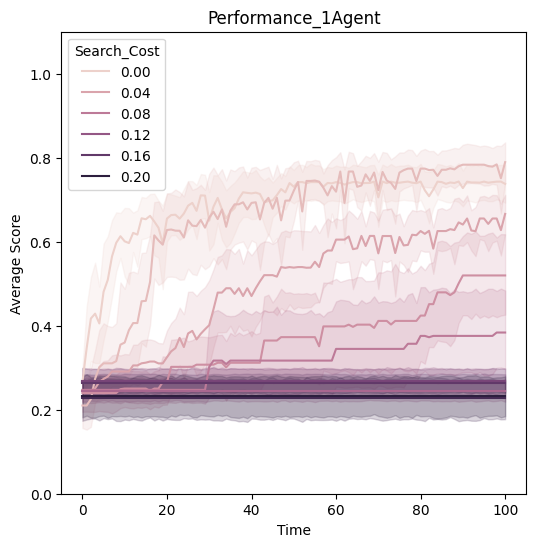

<Figure size 640x480 with 0 Axes>

In [290]:
plt.figure(figsize=(6,6))

sns.lineplot(data=df, x='Step', y='AVG_Value', hue='Search_Cost')

plt.ylim(0,1.1)

plt.xlabel('Time')
plt.ylabel('Average Score')

plt.title(f'Performance_1Agent')
# plt.savefig(f'16AgentPerf_SearchCost.jpg')

plt.show()
plt.clf()

In [293]:
steps = []
step_size = []
sc = []
agentid = []


for pop in sim_hist:
    for agent in pop.agents:
        agent_hist = agent.shared_search_hist.copy()
        amem = agent.memory

        for step in range(1, pop.num_searches+1):
            steps.append(step)

            temp = agent_hist[agent_hist['Step'].isin(list(range(step-amem,step)))]
            self = temp[(temp['AgentID']==agent.id) & (temp['Step']==step-1)]['Location'].apply(str_to_bin).tolist()
    #         print(self)
            neigh = temp[temp['AgentID']!=agent.id]['Location'].apply(str_to_bin).tolist()
    #         print(neigh)
            ls_idx = agent_hist[(agent_hist['Step']==step) & (agent_hist['AgentID']==agent.id)]['Location'].apply(str_to_bin).tolist()
    #         print(ls_idx)
            step_size.append(vectorized_dist(self, neigh, ls_idx)[0])

            sc.append(agent.search_cost)
            agentid.append(agent.id)

data = {'Step': steps,
       'StepSize': step_size,
       'SearchCost': sc,
       'AgentID': agentid}
ss_df = pd.DataFrame(data)

In [303]:
ss_df

,Step,StepSize,SearchCost,AgentID
0,1,1.0,0.0,0
1,2,0.0,0.0,0
2,3,0.0,0.0,0
3,4,0.0,0.0,0
4,5,0.0,0.0,0
...,...,...,...,...
10995,96,0.0,0.2,0
10996,97,0.0,0.2,0
10997,98,0.0,0.2,0
10998,99,0.0,0.2,0


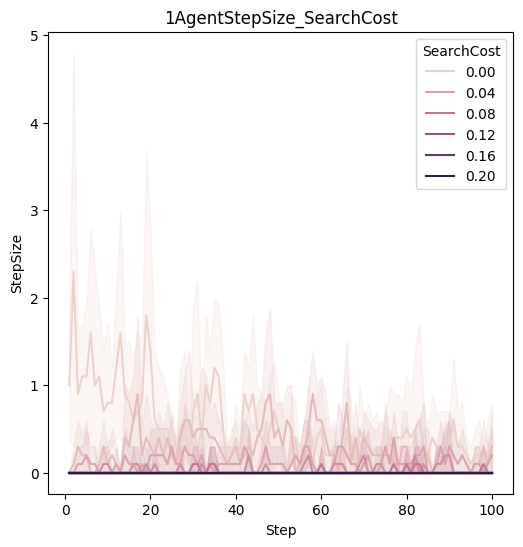

In [294]:
plt.figure(figsize=(6,6))
sns.lineplot(data=ss_df, x='Step', y='StepSize', hue='SearchCost')

plt.title('1AgentStepSize_SearchCost')
# plt.savefig('1AgentStepSize_SearchCost.jpg')

plt.show()

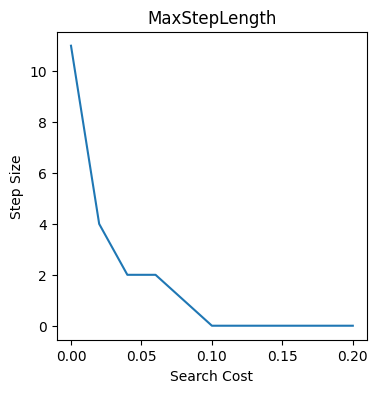

In [296]:
x = []
y = []

for sc_ in sorted(ss_df['SearchCost'].unique()):
    temp = ss_df[ss_df['SearchCost']==sc_].copy()
    x.append(sc_)
    y.append(temp['StepSize'].max())
    
plt.figure(figsize=(4,4))

sns.lineplot(x=x, y=y)

plt.xlabel('Search Cost')
plt.ylabel('Step Size')

plt.title('MaxStepLength')
# plt.savefig('1AgentMaxStepSize_SearchCost.jpg')

plt.show()


In [300]:
x = []
y = []
mem = []
for pop in sim_hist:
    hist_df = hist_df_maker(pop)
    for step in sorted(hist_df['Step'].unique()):
        x.append(step)
        y.append(len(hist_df[hist_df['Step']==step]['Location'].unique()))
        mem.append(pop.agents[0].memory)


<Axes: >

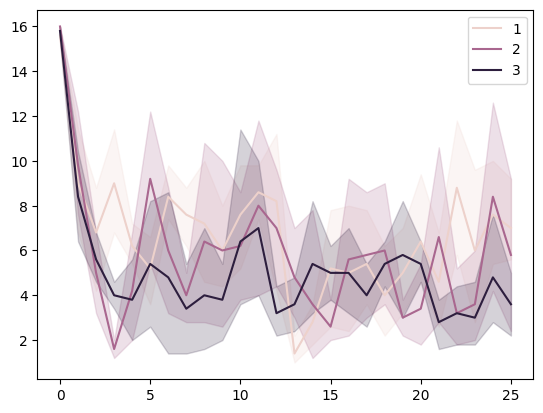

In [301]:
sns.lineplot(x=x, y=y, hue=mem)

In [279]:
hist = sim_hist[0].agents[0].shared_search_hist

step_ = []
avg_locs = []
for pop in sim_hist:
    hist = pop.agents[0].shared_search_hist.copy()
    avg_locs_ = []
    for step in hist['Step'].unique():
        temp = hist[hist['Step']==step].copy()
#         avg_locs_.append(len(temp['Location'].unique()))
        step_.append(step)
        avg_locs.append(len(temp['Location'].unique()))
    
#     avg_locs += avg_locs_

<Axes: >

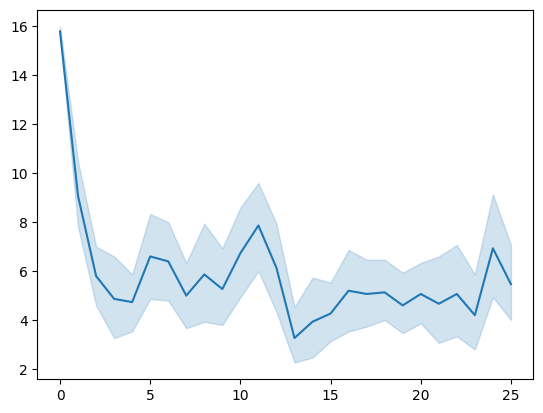

In [284]:
sns.lineplot(x=step_, y=avg_locs)

In [261]:
for each in avg_locs:
    print(np.mean(each))

6.538461538461538
6.346153846153846
6.846153846153846
6.653846153846154
7.1923076923076925
5.384615384615385
6.423076923076923
4.923076923076923
5.461538461538462
7.0
4.846153846153846
4.846153846153846
4.653846153846154
6.153846153846154
5.0
